# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/DL1

/content/drive/MyDrive/DL1


## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [4]:
!pip install sentencepiece

In [5]:
import torch
import numpy as np
from dataset import TextDataset
from torch import nn
from torch.utils.data import DataLoader
from train import train
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm

In [6]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [64]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [10]:
from model import LanguageModel

In [11]:
model = LanguageModel(train_set)

In [12]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

 Я была близка к тому, чтобы сойти с ума во время дебага этого пункта из-за того, что в датасете при перезапуске предыдущих ячеек bpe.model и bpe.vocab не пересоздаются и pad_id

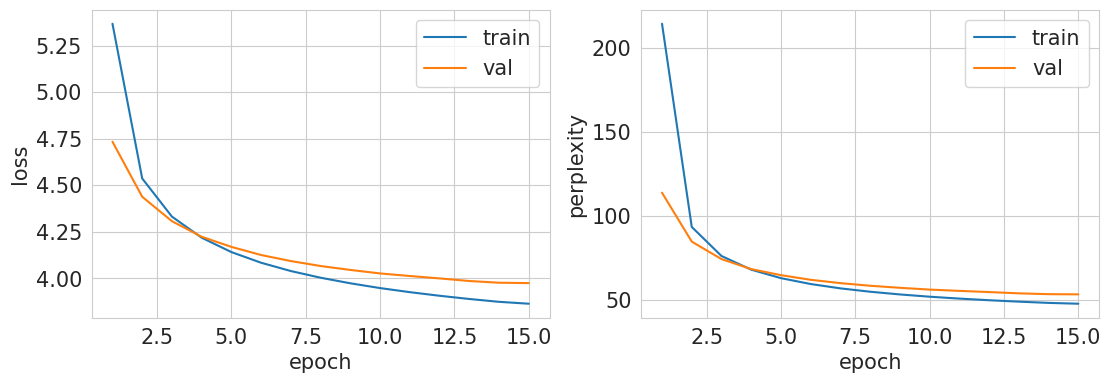

Generation examples:
- мой билетерку в море нельзя пить. какие об есть?
за ноженькой началась 10 лес, почему в мудры отдых залстуки никто не узнают - это как чужое.
ярослеть обращается к видег и говорит- деловее стану жена-лет- ну, как ты гаган, что, которые могут человека мог об этом ожидает с россию?- раз радоваться все! ведь всегда интеллект ничего.
я думала, что лучше всего быть не должен, под дожницей не всегда!
к зюар попросил вырезать, когда сделал коврик. сам всегда думал.


In [ ]:
train_loader = DataLoader(train_set, batch_size=256, shuffle=False)
val_loader = DataLoader(valid_set, batch_size=256, shuffle=False)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LanguageModel(train_set).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

train_losses, val_losses = train(model, optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5),
                                 scheduler = None, train_loader=train_loader, val_loader=val_loader, num_epochs = 15)

In [ ]:
torch.save(model.state_dict(), "RNN_anectodes_v0.pt")

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

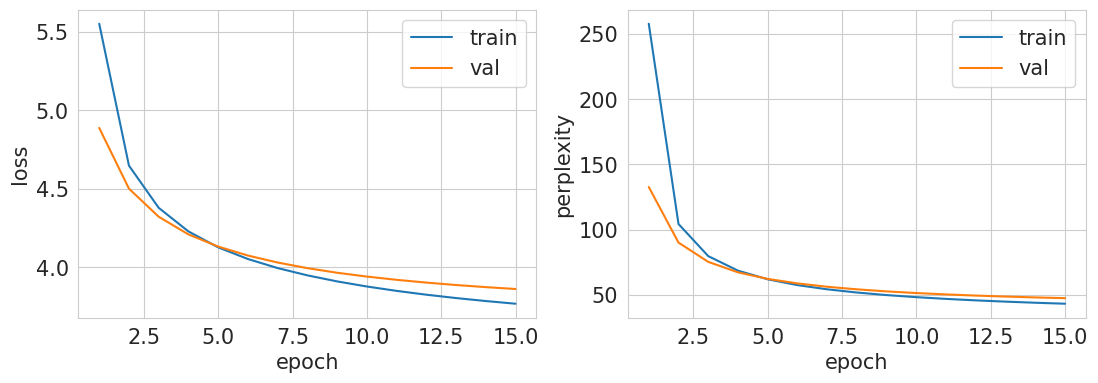

Generation examples:
киевна дубы помню смотри, не мы там все проходыне. помните даже не могут понять как прекраснова, либо никто не может показать пожрать цльвианасты с ужасом. крилке национа дмина своего уникаль отправленно-тешария, но в прошлом году президента россии прокуролища не обрезал свой огменяю рожу если эмиграл и показал, но так нас неожиданно овшлила.
- ну куда у вас в день, упала?- нет!- а чо, настоящий хивструй.- ну, ты восемь минут с атакой хотела церы, а деловым собственным или загляну от голубой.
- причины из окажий дасэдруха- ирый ?- да четыре труда блачилась, если вокруг нее можешь сделать свои папион, в этом смысле.
- робин гуд витаемый восс мировую сусам пиццу так.- прихрал сейзиснут какая-то выходная к моего с пятептации, а я только у меня петя и коньки все новиловые.
- заявил доправля, когда он узнал, когда он был г нигебльками, а что нужно смотреть на незнакомых собак?- да нуля и тише денег, шеф знаете!? этот пельня вышла на работу и тут выбросил.


In [ ]:
model = LanguageModel(dataset=train_set, embed_size=256, hidden_size=256, rnn_type=nn.LSTM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

train_losses, val_losses = train(model, optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5),
                                 scheduler = None, train_loader=train_loader, val_loader=val_loader, num_epochs = 15)

In [ ]:
torch.save(model.state_dict(), "LSTM_anectodes_v0.pt")

Особой разницы между архитектурами не видно, пока анекдоты везде так себе. Но LSTM по метрикам чуть лучше

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

In [ ]:
for prefix in ['купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
  for temp in [0.01, 1, 10, 100, 1000]:
    gen = model.inference(prefix, temp=temp)
    print(f"For prefix {prefix} and temperature {temp}: \n {gen} \n")
  print(f"----------------------------")

For prefix купил мужик шляпу, and temperature 0.01: 
 купил мужик шляпу, а потом говорит- а ты знаешь, что я не могу, я не могу сказать, что я не могу сказать, что я не могу. 

For prefix купил мужик шляпу, and temperature 1: 
 купил мужик шляпу, чему- ну мужик и пришел к врачу и я от грудь до подряженки! 

For prefix купил мужик шляпу, and temperature 10: 
 купил мужик шляпу,вяльсти пядая уда комп свою вста спрашивают яйцапитаите почторок другукаделаремен совер сына вечером буден него сразу-титвают чука пси убе выпи жасно..ужваюцию укра законит телефовочка лорялаго сы посмот вся экстав открываешькет была ко будет работаетмина вимы он2 первый случай женщину мужуретилый сотема жена сами понимаю втодя даже более случалем мной ядохского домойлять девочка иноетествещениебой зият мне путина после тяже были вме я черезпример нашичается своего них пой тогдарии путин? мама неушкилем раза кита 

For prefix купил мужик шляпу, and temperature 100: 
 купил мужик шляпу,чка думашкадитьдца надчитачке

При небольшой температуре (<=1) генерации адекватнее, но менее разнообразные (т.к. генерируются самые вероятные токены), при большой температуре (>1) генерации длиннее и более разнообразные, т.к. распределение постепенно стремится к равномерному, но из-за этого в большом количестве появляются, например, несуществущие слова. Дефолтная температура (1) кажется неплохим выбором

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [ ]:
import os

def pipeline_from_the_start(model_name, vocab_size=2000, tokenizator='bpe'):
  train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix=tokenizator, vocab_size=vocab_size, normalization_rule_name='nmt_nfkc_cf', model_type=tokenizator)
  valid_set = TextDataset(data_file='jokes.txt', train=False, vocab_size=vocab_size, sp_model_prefix=tokenizator, normalization_rule_name='nmt_nfkc_cf', model_type=tokenizator)
  train_loader = DataLoader(train_set, batch_size=256, shuffle=False)
  val_loader = DataLoader(valid_set, batch_size=256, shuffle=False)
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  model = LanguageModel(dataset=train_set, embed_size=256, hidden_size=256, rnn_type=nn.LSTM).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

  train_losses, val_losses = train(model, optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5),
                                  scheduler = None, train_loader=train_loader, val_loader=val_loader, num_epochs = 15)
  torch.save(model.state_dict(), model_name)



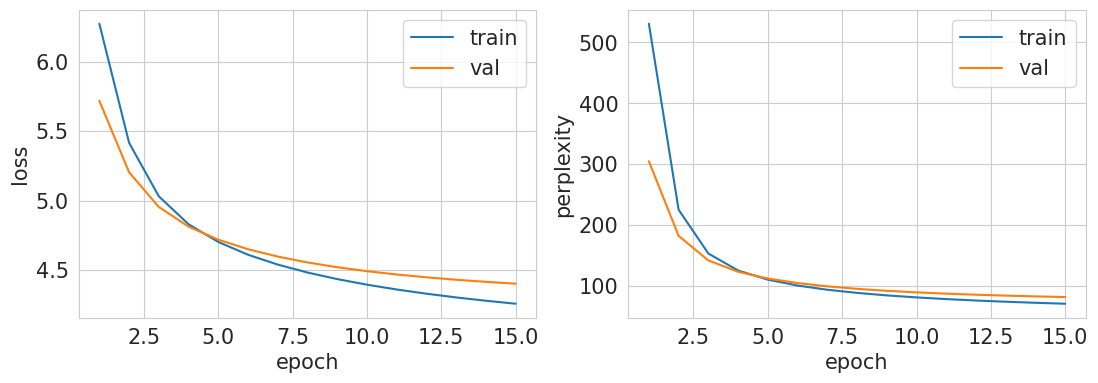

Generation examples:
- вася, девочки, по радиодарьму приезжает к сою содарвы!- так почему же я сказал, что здесь маленькие недостатки?
- как тебе удалось договориться с при скажу к тебе в том, как ее нужно?- не с кем...
- как тебе отсутствие повтор совести?- мужики, контратырыются полицейским!- ну, пойдем со своими сторонами!
у жены в конкурсе красотусыновской власти не открывают души на военкомате и психлет.
- мне можно болеть!- потому что во послаливаю ан чем два раза.- ей можно?. а за 200 доловеков, у него все, на них... может, первые места у идиотов, сделайте их специализу и терпиром-то и своим первым отригуют...


In [ ]:
pipeline_from_the_start("LSTM_v1_5k_tokens.pt", vocab_size=5000)

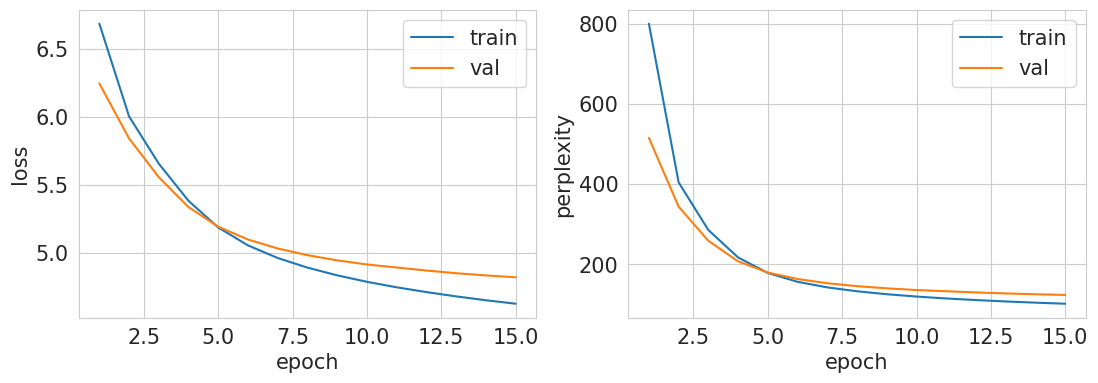

Generation examples:
- рабинович означает, что столкнулись сына на знаменитных мнениях?- сакинов на освободовших зал строятся три диапаками.
когда тет письмо спрашивают, что легко будет умнее мужчин, чтобы выпнищивать третим. чаще всего футболист она себя ищет...
- представляешь, вчера я наступаюсь в лифте, на первом сидит в магазине.- почему?- ерунда сконкакал, а вдруг приходит собакой.- мона, мяг редак, давай за пчедем.- правда, курить купим, батянитесь!- покажите водки пораньше.
сначала пришла под какальным верхним.
на операционного тренировок- слушай, ты меня не дома, значит ты человека дураком, я ухожу.


In [ ]:
pipeline_from_the_start("LSTM_v1_10k_tokens.pt", vocab_size=10000)

Я думала обучить еще на 20к токенах, но тут уже стало понятно, что при увеличении количества токенов метрики падают. Переходим к unigram

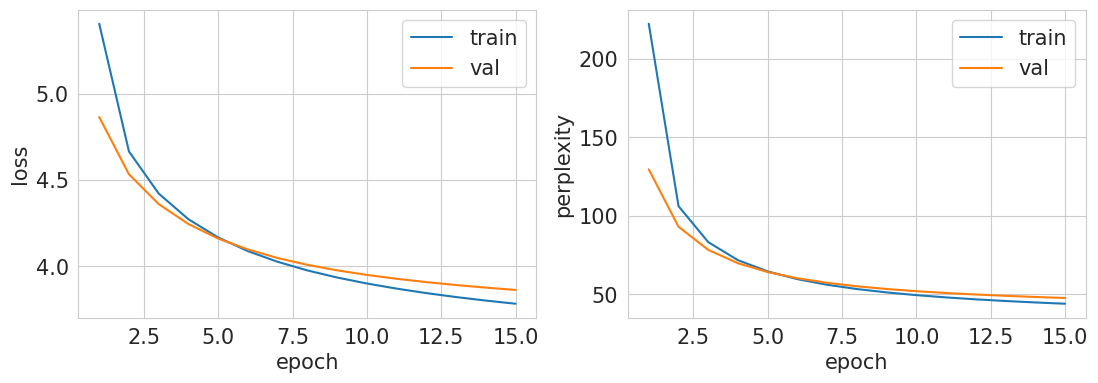

Generation examples:
россияне ушли представляю - сердце ремотим другого телефона.
- социальный зачем? это любовь авто зонт? мне именно родители, мозги в зарабатываю!
- что это тебе воскресенье не помочь?- на своей жене можно подъезжать спину?- а я с ним ей не хочется тебя найти!
девушка - как разница между компомоноватом, постает с водки и говорит, как слами дома, напивают ее враск. выясняется косы- что случилось? вон не екниже замены меня!
идеальной матрией, завязня от всегочки михаревич и назвали дволю с руслетмой.


In [ ]:
pipeline_from_the_start("LSTM_v2_unigram_tokenizations.pt", vocab_size=2000, tokenizator='unigram')

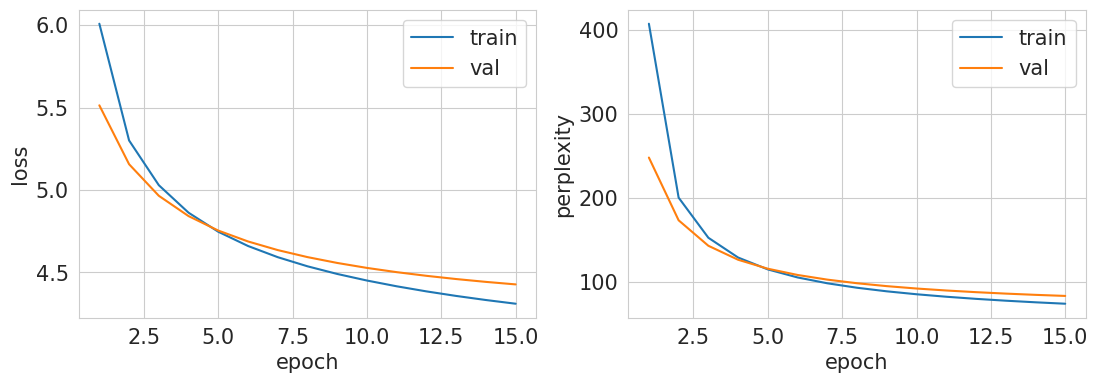

Generation examples:
- надо теще новую стать этим нашла, детей и духи следову!- конечно родители, я с ним познакомился...
 ⁇ 0 дней раздражен по голове зладим фраза другого приходится истолый мужчина, или собак станет?
- доктор, вчера отправил опыт до мазалась на последнюю в туалете в день с троихского холодильника. мой дневник на новый год усиленно не разговаривать с заменами.- нет, вы ничем не пела. и только в чем делом собственно, когда начинаетволиться переводить, не подозревствовать.
- профессор, а не подскажете, в жизни есть месяцев?- да ты один отпуск пиво опять сходил и нанесем!
- доктор, дайте вашу мат по старителем автоменьше.- сколько?! ты знаешь, кому вдруг в этом разворочник будет! сын- да иди, а я не могу!


In [ ]:
pipeline_from_the_start("LSTM_v2_unigram_5k_tokens_tokenizations.pt", vocab_size=5000, tokenizator='unigram')

На большем словаре у меня немного растет loss и сильно взлетает perplexity. (видимо из-за того, что модель должна выбирать из большего числа возможных токенов, вероятность каждого токена ниже)

А вообще сравнивать perplexity в моделях с разным vocab_size по идее неправильно, так как метрика напрямую зависит от количества токенов, которое напрямую зависит от размера словаря. А вот для разных токенизаторов, наверное, проблемы нет

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [ ]:
def create_texts_corpus(model, valid_set):
  validation_texts = []
  for indices, length in valid_set:
      validation_texts.append(valid_set.ids2text(indices[:length]))
  N = len(validation_texts)
  generated_texts = []
  for _ in tqdm(range(N)):
    generated_texts.append(model.inference())
  return validation_texts, generated_texts

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

def compute_lsa_metric(validation_texts, generated_texts, model_name):
    corpus = validation_texts + generated_texts

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)

    svd = TruncatedSVD(n_components=100, random_state=42)
    lsa_matrix = svd.fit_transform(tfidf_matrix)

    X_val = lsa_matrix[:len(validation_texts)]
    X_gen = lsa_matrix[len(validation_texts):]

    vectors_of_similarity[model_name] = lsa_matrix

    cosine_sim = cosine_similarity(X_gen, X_val)
    return np.mean(np.max(cosine_sim, axis=1))


In [ ]:
class Datasets:
  #чтобы больше заново не создавать train и val sets
    def __init__(self, data_file='jokes.txt', normalization_rule_name='nmt_nfkc_cf'):
        self.data_file = data_file
        self.norm_rule = normalization_rule_name
        self.datasets = {}

    def get_dataset(self, vocab_size, model_type, train=True):
        key = f"{model_type}_{vocab_size}_{'train' if train else 'valid'}"
        if key not in self.datasets:
            self.datasets[key] = TextDataset(
                data_file=self.data_file,
                train=train,
                vocab_size=vocab_size,
                sp_model_prefix=model_type,
                normalization_rule_name=self.norm_rule,
                model_type=model_type
            )
        return self.datasets[key]




In [ ]:
datasets= Datasets()
results = {}
vectors_of_similarity = {}

In [ ]:
def get_results_for_lsa(model_name, rnn_type):
    vocab_size = 5000 if '5k' in model_name else 10000 if '10k' in model_name else 2000
    tokenizator = 'unigram' if 'unigram' in model_name else 'bpe'

    train_set = datasets.get_dataset(vocab_size, tokenizator, train=True)
    valid_set = datasets.get_dataset(vocab_size, tokenizator, train=False)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = LanguageModel(dataset=train_set, embed_size=256, hidden_size=256, rnn_type=rnn_type).to(device)
    model.load_state_dict(torch.load(model_name, weights_only=False))

    validation_texts, generated_texts = create_texts_corpus(model, valid_set)
    result = compute_lsa_metric(validation_texts, generated_texts, model_name)

    results[model_name] = result
    return result

In [ ]:
for filename in os.listdir('.'):
    if filename.endswith('.pt'):
        print(filename)
        prefix = filename.split('_')[0]
        if prefix == 'LSTM':
            rnn_type = nn.LSTM
        elif prefix == 'RNN': #тоже осталось когда все модели перебирала
            rnn_type = nn.RNN
        get_results_for_lsa(filename, rnn_type)

In [ ]:
pd.DataFrame([results])

,LSTM_v2_unigram_tokenizations.pt,LSTM_anectodes_v0.pt,LSTM_v1_10k_tokens.pt
0,0.698929,0.708559,0.700259


In [ ]:
pd.DataFrame([results]) #тут пробовала все модели, осталось старое, пусть будет для показатлея того, что у моделей могут быть сильнее различия в lsa

,LSTM_v1_10k_tokens.pt,LSTM_v1_5k_tokens.pt,RNN_anectodes_v0.pt,LSTM_anectodes_v0.pt,LSTM_v2_unigram_tokenizations.pt,LSTM_v2_unigram_5k_tokens_tokenizations.pt
0,0.701038,0.687023,0.701195,0.709031,0.702203,0.686617


Плюсы:
- можем напрямую сравнивать модели
- поскольку это семантическая оценка, то это имеет больше интуитивно понятного смысла о том, насколько хороша генерация
- SVD должен снижать шум

Минусы:
- сильно чувствительная к длине текстов метрика
- может быть очень тяжело вычислительно считать TF_IDF и еще и раскладывать SVD

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

In [ ]:
def visualize_text_embeddings(model_name):
    lsa_matrix = vectors_of_similarity[model_name]

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_vectors = tsne.fit_transform(lsa_matrix)

    N = lsa_matrix.shape[0] // 2
    labels = np.array(["validation"] * N + ["generated"] * N)
    colors = np.array(['blue' if label == "validation" else 'red' for label in labels])

    plt.figure(figsize=(12, 6))

    for label, color in zip(["validation", "generated"], ['blue', 'red']):
        indices = labels == label
        plt.scatter(tsne_vectors[indices, 0], tsne_vectors[indices, 1],
                    c=color, label=label, alpha=0.6)

    plt.title(f"t-SNE Visualization ({model_name.split('.')[0]})")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.show()



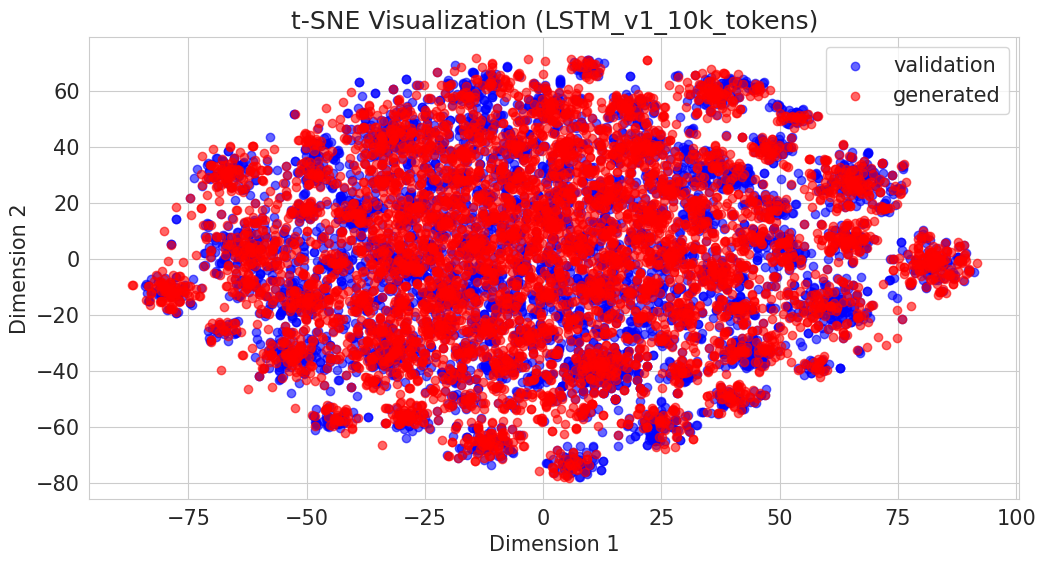

In [ ]:
visualize_text_embeddings("LSTM_v1_10k_tokens.pt")

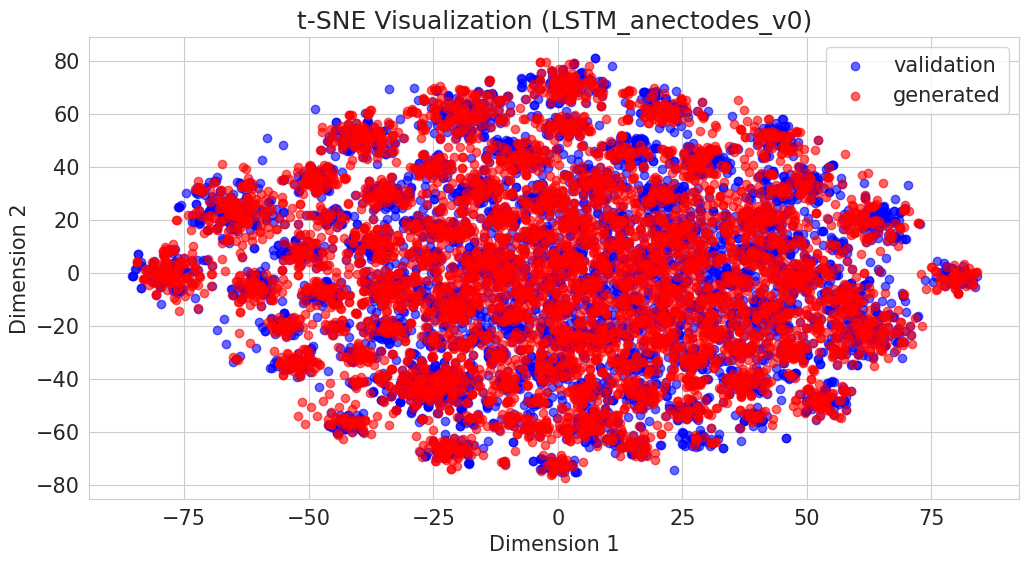

In [ ]:
visualize_text_embeddings("LSTM_anectodes_v0.pt")

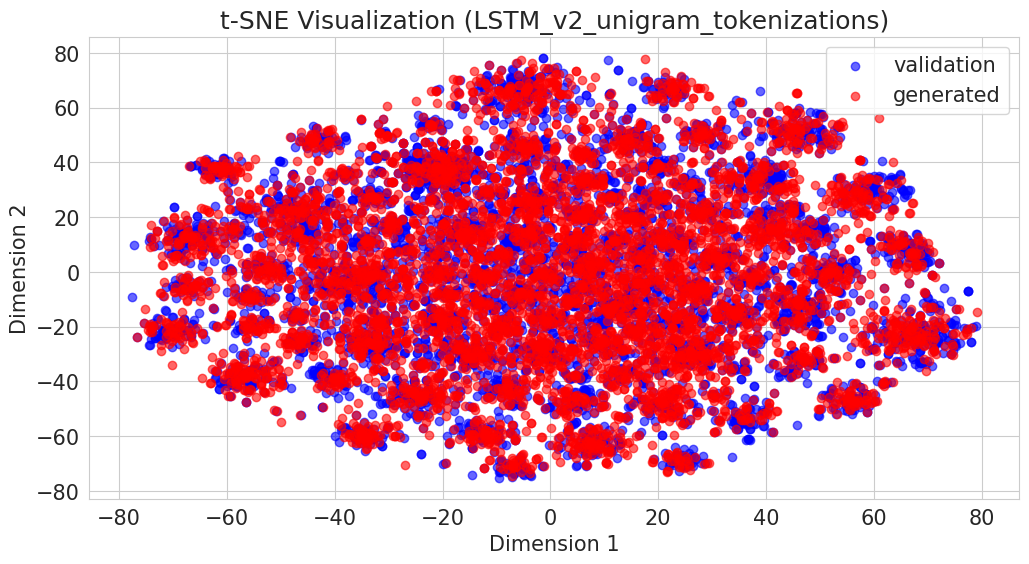

In [ ]:
visualize_text_embeddings("LSTM_v2_unigram_tokenizations.pt")

В общем если смотреть по графикам, то валидационные и сгенерированные тексты должны быть похожи друг на друга

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [ ]:
%pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
model_checkpoint = 'ai-forever/rugpt3small_based_on_gpt2'

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
gpt = AutoModelForCausalLM.from_pretrained(model_checkpoint).to(device)

In [32]:
def get_LSTM_model_texts(model_name):
    vocab_size = 5000 if '5k' in model_name else 10000 if '10k' in model_name else 2000
    tokenizator = 'unigram' if 'unigram' in model_name else 'bpe'

    train_set = datasets.get_dataset(vocab_size, tokenizator, train=True)
    valid_set = datasets.get_dataset(vocab_size, tokenizator, train=False)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = LanguageModel(dataset=train_set, embed_size=256, hidden_size=256, rnn_type=nn.LSTM).to(device)
    model.load_state_dict(torch.load(model_name, weights_only=False))

    _, generated_texts = create_texts_corpus(model, valid_set)

    return model, generated_texts

In [39]:
#полностью скопировано с предоставленной ссылки про подсчет perplexity
def perplexity(model_name, gpt_model):
    model, gen_texts = get_LSTM_model_texts(model_name)
    encodings = tokenizer("\n\n".join([gen_texts[i] for i in range(len(gen_texts))]), return_tensors="pt")
    max_length = gpt_model.config.n_positions
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nll_sum = 0.0
    n_tokens = 0
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = gpt_model(input_ids, labels=target_ids)

            # loss is calculated using CrossEntropyLoss which averages over valid labels
            # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
            # to the left by 1.
            neg_log_likelihood = outputs.loss

        # Accumulate the total negative log-likelihood and the total number of tokens
        num_valid_tokens = (target_ids != -100).sum().item()  # number of valid tokens in target_ids
        batch_size = target_ids.size(0)
        num_loss_tokens = num_valid_tokens - batch_size  # subtract batch_size due to internal label shift
        nll_sum += neg_log_likelihood * num_loss_tokens
        n_tokens += num_loss_tokens

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    avg_nll = nll_sum / n_tokens  # average negative log-likelihood per token
    ppl = torch.exp(avg_nll)

    return ppl


In [ ]:
perplexity_10k = perplexity('LSTM_v1_10k_tokens.pt', gpt)
perplexity_lstm = perplexity('LSTM_anectodes_v0.pt', gpt)
perplexity_unigram = perplexity('LSTM_v2_unigram_tokenizations.pt', gpt)

In [49]:
print(f"Perplexity for my LSTM (10k tokens) is {perplexity_10k}")

Perplexity for my LSTM (10k tokens) is 573.7844848632812


In [50]:
print(f"Perplexity for my base LSTM is {perplexity_lstm}")

Perplexity for my base LSTM is 598.05712890625 


In [52]:
print(f"Perplexity for my LSTM (unigram) is {perplexity_unigram}")

Perplexity for my LSTM (unigram) is 573.9878540039062 


Большая модель недовольна качеством генерации...

По получившимся значениям perplexity победила базовая LSTM с BPE, впрочем LSTM с unigram достаточно близко к ней

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

**подумал штирлиц и не выдержал.**